# **Summary**
This notebook will explore some business questions that a shareholder may want on insights on to improve their business. We will dive deeper into the questions using statistical analysis and visualizations.

**Business Questions:**

- What was the turnover rate? What was the retention rate? What is the overall net growth of the company?
- Is there a relationship between employee satisfaction (engagement) and their performance?
- How is the employee engagement rate based on age, gender, and race?
- Is there any relationship between who a person works for and their performance score? What about their satisfaction?
- What is the overall diversity profile of the organization?
- What are our best recruiting sources if we want to ensure a diverse organization?
- Are there areas of the company where pay is not equitable?

In [ ]:
# import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import chi2_contingency, ttest_ind, shapiro, levene, mannwhitneyu

pd.set_option('display.max_columns', None)

# import data
stat_df = pd.read_csv("stat_HRDataset.csv")
df=pd.read_csv("cleaned_HRDataset.csv")

In [ ]:
stat_df.drop(columns=['Employee_Name', 'EmpID','ManagerID', 'State', 'Zip', 'DOB', 'EmpStatusID', 'MarriedID',
                 'MaritalStatusID',	'DeptID', 'PositionID'], inplace=True)

df.drop(columns=['Employee_Name', 'EmpID','ManagerID', 'State', 'Zip', 'DOB', 'EmpStatusID', 'MarriedID',
                 'MaritalStatusID',	'DeptID', 'PositionID'], inplace=True)

df.head()

,GenderID,PerfScoreID,FromDiversityJobFairID,Salary,Termd,Position,Sex,MaritalDesc,CitizenDesc,HispanicLatino,RaceDesc,DateofHire,DateofTermination,TermReason,EmploymentStatus,Department,ManagerName,RecruitmentSource,PerformanceScore,EngagementSurvey,EmpSatisfaction,SpecialProjectsCount,LastPerformanceReview_Date,DaysLateLast30,Absences,Age,Tenure,DiversityStatus,DeptAverageSalary,Salary_Dept_Ratio,DeptAveragePerfScore,PerformanceStandard,DaysSinceLastReview
0,1,4,0,62506,0,Production Technician I,M,Single,US Citizen,No,White,2011-07-05,NaN,Still Employed,Active,Production,Michael Albert,LinkedIn,Exceeds,4.60,5,0,2019-01-17,0,1,36,8.490075,Non-Diverse,59967.788462,1.042326,2.980769,1,348
1,1,3,0,104437,1,Sr. DBA,M,Married,US Citizen,No,White,2015-03-30,2016-06-16,Career Change,Voluntarily Terminated,IT/IS,Simon Roup,Indeed,Fully Meets,4.96,3,6,2016-02-24,0,17,44,1.215606,Non-Diverse,97064.640000,1.075953,3.060000,0,113
2,0,3,0,64955,1,Production Technician II,F,Married,US Citizen,No,White,2011-07-05,2012-09-24,Attendance,Voluntarily Terminated,Production,Kissy Sullivan,LinkedIn,Fully Meets,3.02,3,0,2012-05-15,0,3,31,1.223819,Non-Diverse,59967.788462,1.083165,2.980769,1,132
3,0,3,0,64991,0,Production Technician I,F,Married,US Citizen,No,White,2008-01-07,NaN,Still Employed,Active,Production,Elijiah Gray,Indeed,Fully Meets,4.84,5,0,2019-01-03,0,15,31,11.980835,Non-Diverse,59967.788462,1.083765,2.980769,1,362
4,0,3,0,50825,1,Production Technician I,F,Divorced,US Citizen,No,White,2011-07-11,2016-09-06,Education,Voluntarily Terminated,Production,Webster Butler,Google Search,Fully Meets,5.00,4,0,2016-02-01,0,2,30,5.158111,Non-Diverse,59967.788462,0.847538,2.980769,1,218


# **Employee Lifecycle & Company Health Analysis**
- What was the turnover rate? What was the retention rate? What is the overall net growth of the company?



### **Year by Year Analysis**

In [ ]:
df['DateofHire'] = pd.to_datetime(df['DateofHire'], errors='coerce')
df['DateofTermination'] = pd.to_datetime(df['DateofTermination'], errors='coerce')

start_year = 2010
end_year = 2018
years = range(start_year, end_year + 1)

yearly_termination_counts = {year: 0 for year in years}

for year in years:
    # employees terminated in this year
    terminated_in_year = df[(df['DateofTermination'].dt.year == year) & (df['Termd'] == 1)]
    yearly_termination_counts[year] = len(terminated_in_year)

termination_by_year = pd.DataFrame({
    'Year': list(yearly_termination_counts.keys()),
    'TerminatedEmployees': list(yearly_termination_counts.values())
})

In [ ]:
yearly_data = []

for year in years:
    # employees terminated in the year
    terminated = df[(df['DateofTermination'].dt.year == year) & (df['Termd'] == 1)]
    terminated_count = len(terminated)

    # employees active in the year (hired before or in the year and not terminated that year)
    retained = df[
        (df['DateofHire'].dt.year <= year) &
        ((df['DateofTermination'].isnull()) | (df['DateofTermination'].dt.year > year))
    ]
    retained_count = len(retained)

    yearly_data.append({'Year': year, 'Terminated': terminated_count, 'Active': retained_count})

turnover_retention_df = pd.DataFrame(yearly_data)

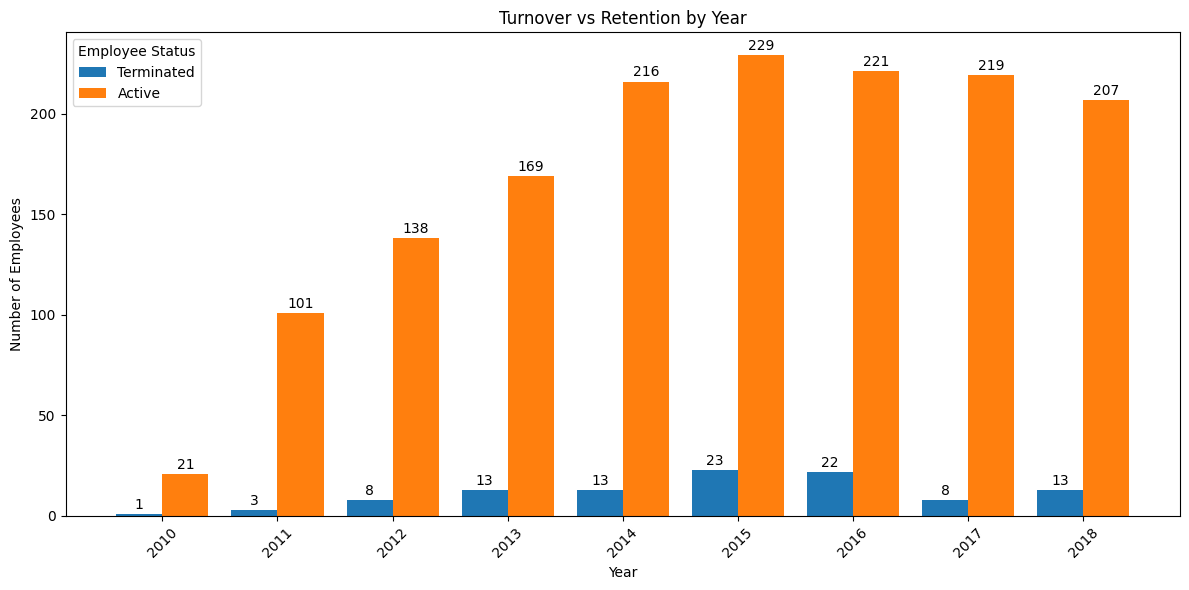

In [ ]:
# turnover vs retention by year
plt.figure(figsize=(12, 6))
bar_width = 0.4
x = np.arange(len(turnover_retention_df['Year']))

terminated_bars = plt.bar(x - bar_width / 2, turnover_retention_df['Terminated'], width=bar_width, label='Terminated')
active_bars = plt.bar(x + bar_width / 2, turnover_retention_df['Active'], width=bar_width, label='Active')

# add counts above bars
for bar in terminated_bars:
    plt.text(bar.get_x() + bar.get_width() / 2,
             bar.get_height() + 1,
             f'{bar.get_height():.0f}',
             ha='center',
             va='bottom')

for bar in active_bars:
    plt.text(bar.get_x() + bar.get_width() / 2,
             bar.get_height() + 1,
             f'{bar.get_height():.0f}',
             ha='center',
             va='bottom')

plt.title('Turnover vs Retention by Year')
plt.xlabel('Year')
plt.ylabel('Number of Employees')
plt.xticks(x, turnover_retention_df['Year'], rotation=45)
plt.legend(title='Employee Status')
plt.tight_layout()
plt.show()

### **Overall Analysis**

<ipython-input-36-0c3c599c79fa>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(x="Department", data=df[df['Termd'] == 1], palette="tab10")


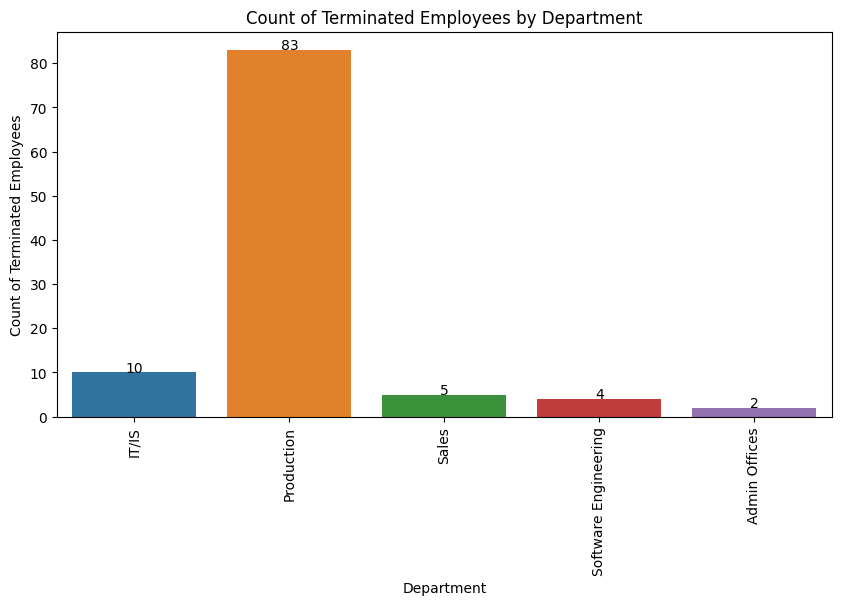

In [ ]:
# total terminated employees by department
plt.figure(figsize=(10, 5))
ax = sns.countplot(x="Department", data=df[df['Termd'] == 1], palette='tab10')

for p in ax.patches:
    ax.text(p.get_x() + p.get_width()/2,
            p.get_height() + 1,
            f'{p.get_height():.0f}',
            ha='center',
            va='center')

plt.title("Count of Terminated Employees by Department")
plt.xlabel("Department")
plt.ylabel("Count of Terminated Employees")
plt.xticks(rotation=90)
plt.show()

<ipython-input-37-9e3d047c29c4>:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x="Department",


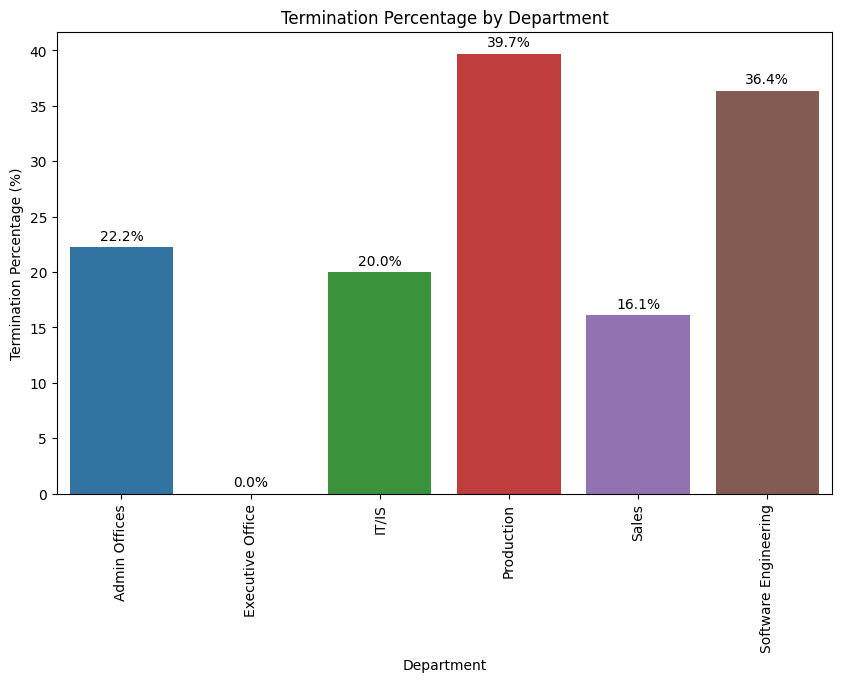

In [ ]:
# termination percentage by department
termination_percentage = df.groupby('Department')['Termd'].mean().reset_index()
termination_percentage.columns = ['Department', 'Termination Percentage']
termination_percentage['Termination Percentage'] = termination_percentage['Termination Percentage'] * 100

plt.figure(figsize=(10, 6))
ax = sns.barplot(x="Department",
                 y="Termination Percentage",
                 data=termination_percentage,
                 palette='tab10')

for p in ax.patches:
    ax.text(p.get_x() + p.get_width()/2,
            p.get_height() + 1,
            f'{p.get_height():.1f}%',
            ha='center',
            va='center')

plt.title('Termination Percentage by Department')
plt.xlabel('Department')
plt.ylabel('Termination Percentage (%)')
plt.xticks(rotation=90)
plt.show()

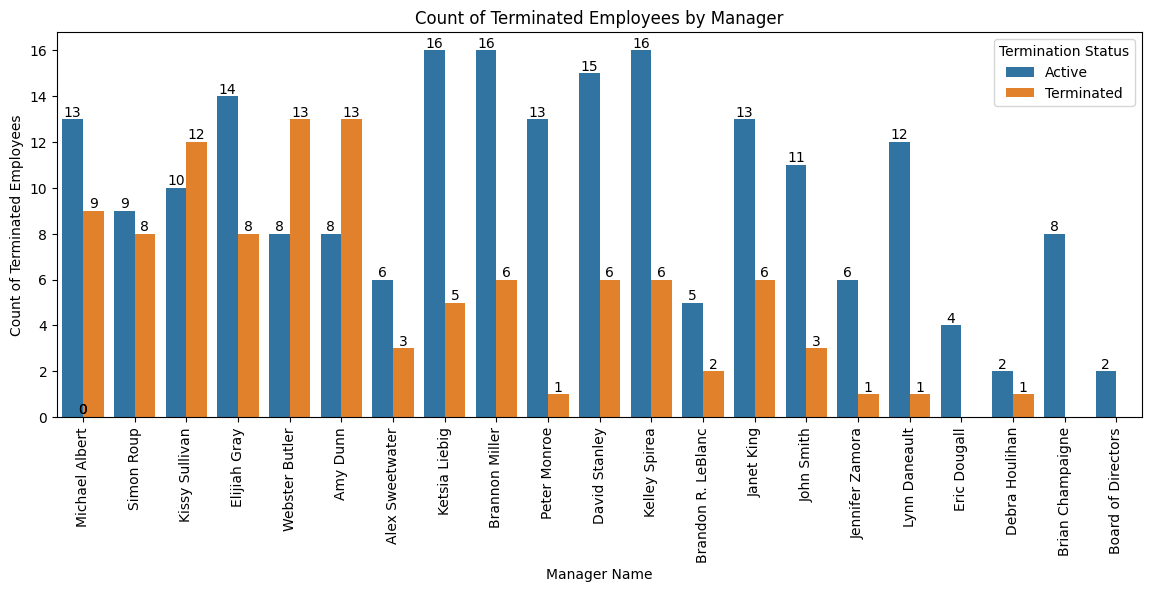

In [ ]:
# count of terminated employees by manager
plt.figure(figsize=(14, 5))
ax = sns.countplot(x="ManagerName",
                   hue="Termd",
                   data=df)

for p in ax.patches:
    ax.text(p.get_x() + p.get_width()/2,
            p.get_height() + 0.3,
            f'{p.get_height():.0f}',
            ha='center',
            va='center')

plt.title('Count of Terminated Employees by Manager')
plt.xlabel('Manager Name')
plt.ylabel('Count of Terminated Employees')
plt.xticks(rotation=90)
plt.legend(title='Termination Status', labels=['Active', 'Terminated'])
plt.show()

<ipython-input-39-817b0244f0ab>:9: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  ax = sns.barplot(x="ManagerName",


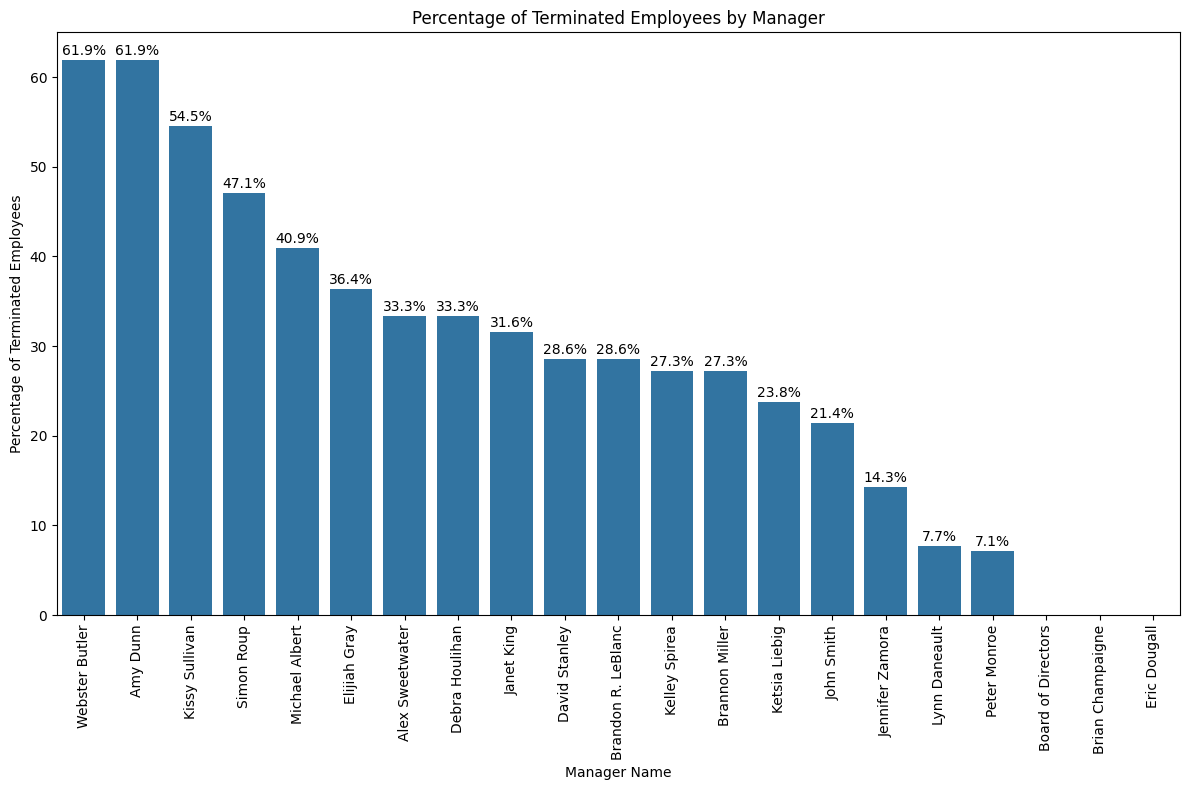

In [ ]:
# calc terminated percentage of terminated by manager
terminated_pct = df[df['Termd'] == 1].groupby("ManagerName").size().div(df.groupby("ManagerName").size()).mul(100).reset_index(name="Terminated Pct")

# sort by desc order
terminated_pct = terminated_pct.sort_values('Terminated Pct', ascending=False)

# percentage of terminated employees by manager
plt.figure(figsize=(12, 8))
ax = sns.barplot(x='ManagerName',
                 y='Terminated Pct',
                 data=terminated_pct,
                 ci=None)

for p in ax.patches:
    ax.text(p.get_x() + p.get_width()/2,
            p.get_height() + 1,
            f'{p.get_height():.1f}%',
            ha='center',
            va='center')

plt.title('Percentage of Terminated Employees by Manager')
plt.xlabel('Manager Name')
plt.ylabel('Percentage of Terminated Employees')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

### **Summary**
- **Steady Growth**: Reached 229 employees by 2019 (healthy expansion).
- **Retention Success**: Stable termination rates overall suggest effective company-wide retention strategies.
- **Production Department Risk**: Highest termination volume signals potential issues in:
  - **Workload balance** -- conduct *workload analysis* by comparing turnover rates vs overtime hours/production targets.
  - **Role satisfaction** -- analyze promotion rates in Production vs. other departments.
  - Managerial support
- **Manager-Specific Risk:** Webster Butler and Amy Dunn have disproportionately high termination rates under their leadership, indicating:
  - Possible communication gaps
  - Mismatched management style
  - Unclear performance expectations
  - **Interventions:** Conduct feedback by surveying teams on leadership effectiveness. Introduce coaching programs, pairing top-performing managers with low_performing managers.

# **Employee Engagement Rate Analysis**
- Is there a relationship between employee satisfaction (engagement) and their performance?
- How is the employee engagement rate based on age, gender, and race?

<ipython-input-40-ce944322bf50>:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=df['PerformanceScore'], palette = "tab10")


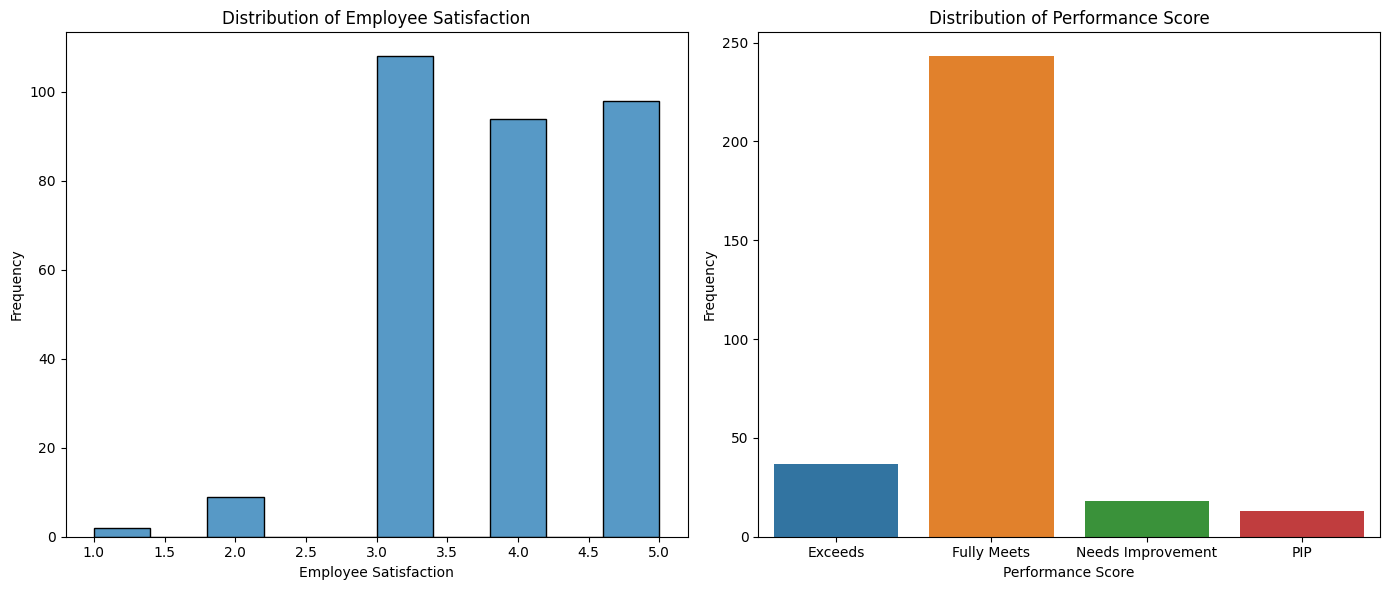

In [ ]:
plt.figure(figsize=(14, 6))

# employee satisfaction
plt.subplot(1, 2, 1)
sns.histplot(df['EmpSatisfaction'], bins=10)
plt.title('Distribution of Employee Satisfaction')
plt.xlabel('Employee Satisfaction')
plt.ylabel('Frequency')

# performance score
plt.subplot(1, 2, 2)
sns.countplot(x=df['PerformanceScore'], palette = 'tab10')
plt.title('Distribution of Performance Score')
plt.xlabel('Performance Score')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

In [ ]:
contingency_table = pd.crosstab(df['EmpSatisfaction'], df['PerformanceScore'])

chi2, p, dof, expected = chi2_contingency(contingency_table)
print(f'Chi-squared statistic: {chi2:.2f}')
print(f'p-value: {p:.4f}')

if p < 0.05:
    print("There is a statistically significant association between Employee Satisfaction and Performance Score.")
else:
    print("There is no statistically significant association between Employee Satisfaction and Performance Score.")

Chi-squared statistic: 148.08
p-value: 0.0000
There is a statistically significant association between Employee Satisfaction and Performance Score.


<ipython-input-42-72a6a7113343>:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=df['Sex'],
<ipython-input-42-72a6a7113343>:23: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=df['RaceDesc'],


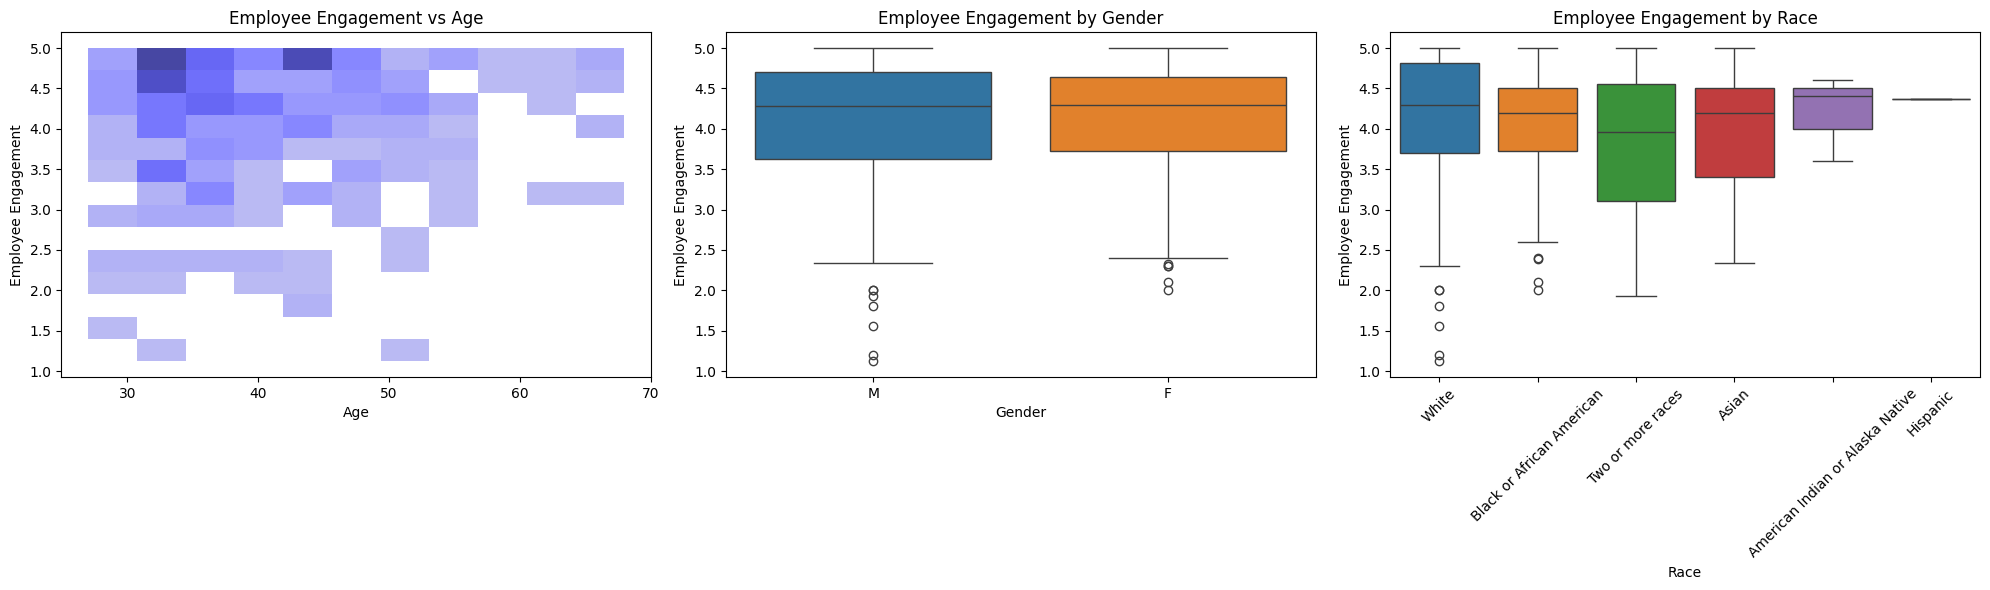

In [ ]:
plt.figure(figsize=(20, 6))

# 1. employee engagement vs gge
plt.subplot(1, 3, 1)
sns.histplot(x=df['Age'],
             y=df['EngagementSurvey'],
             color='blue')
plt.title('Employee Engagement vs Age')
plt.xlabel('Age')
plt.ylabel('Employee Engagement')

# 2. employee engagement vs gender
plt.subplot(1, 3, 2)
sns.boxplot(x=df['Sex'],
            y=df['EngagementSurvey'],
            palette="tab10")
plt.title('Employee Engagement by Gender')
plt.xlabel('Gender')
plt.ylabel('Employee Engagement')

# 3. employee engagement vs race
plt.subplot(1, 3, 3)
sns.boxplot(x=df['RaceDesc'],
            y=df['EngagementSurvey'],
            palette="tab10")
plt.title('Employee Engagement by Race')
plt.xlabel('Race')
plt.xticks(rotation=45)
plt.ylabel('Employee Engagement')

plt.tight_layout()
plt.show()

In [ ]:
contingency_table_age = pd.crosstab(df['EmpSatisfaction'], df['Age'])

chi2, p, dof, expected = chi2_contingency(contingency_table_age)
print(f'Chi-squared statistic: {chi2:.2f}')
print(f'p-value: {p:.4f}')

if p < 0.05:
    print("There is a statistically significant association between Employee Satisfaction and Age.")
else:
    print("There is no statistically significant association between Employee Satisfaction and Age.")

Chi-squared statistic: 129.98
p-value: 0.8541
There is no statistically significant association between Employee Satisfaction and Age.


In [ ]:
contingency_table_gender = pd.crosstab(df['EmpSatisfaction'], df['Sex'])

chi2, p, dof, expected = chi2_contingency(contingency_table_gender)
print(f'Chi-squared statistic: {chi2:.2f}')
print(f'p-value: {p:.4f}')

if p < 0.05:
    print("There is a statistically significant association between Employee Satisfaction and Gender.")
else:
    print("There is no statistically significant association between Employee Satisfaction and Gender.")

Chi-squared statistic: 4.96
p-value: 0.2918
There is no statistically significant association between Employee Satisfaction and Gender.


In [ ]:
contingency_table_race = pd.crosstab(df['EmpSatisfaction'], df['RaceDesc'])

chi2, p, dof, expected = chi2_contingency(contingency_table_race)
print(f'Chi-squared statistic: {chi2:.2f}')
print(f'p-value: {p:.4f}')

if p < 0.05:
    print("There is a statistically significant association between Employee Satisfaction and Race.")
else:
    print("There is no statistically significant association between Employee Satisfaction and Race.")

Chi-squared statistic: 15.09
p-value: 0.7714
There is no statistically significant association between Employee Satisfaction and Race.


### **Summary**
**1. Employee Satisfaction and Demographics (Race, Gender, Age):**
  - There is no statistically significant association between employee satisfaction and race (p = 0.7714), gender (p = 0.2918), or age (p = 0.8541).
  - This suggests that employee satisfaction levels are consistent across different demographic groups, indicating that factors like age, gender, and race do not influence overall engagement levels significantly.

**2. Employee Satisfaction and Performance Score:**
  - There is a statistically significant association between employee satisfaction and performance score (p = 0.0000).
  - This indicates that employees with higher satisfaction levels tend to perform better, aligning with the observation from the graphs that most employees with higher satisfaction ("Fully Meets" and "Exceeds" performance categories) are more engaged.
    - **Improving satisfaction directly boosts productivity and retention of top talent.**

Strategies to improve performance should prioritize enhancing employee satisfaction as satisfaction directly correlates with better performance outcomes. Strategies do not have to focus on targeting demographics since satisfaction does not vary significantly by demographic factors (specific to age, gender, or racial groups).
- Implement employee surveys to identify satisfactory/motivation drivers
- Reward consistency
- Address low performers by mandating biweekly check-in to discover root cause.

# **Management Analysis**
- Is there any relationship between who a person works for and their performance score? What about their satisfaction?

<ipython-input-46-9d89b1d4c415>:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


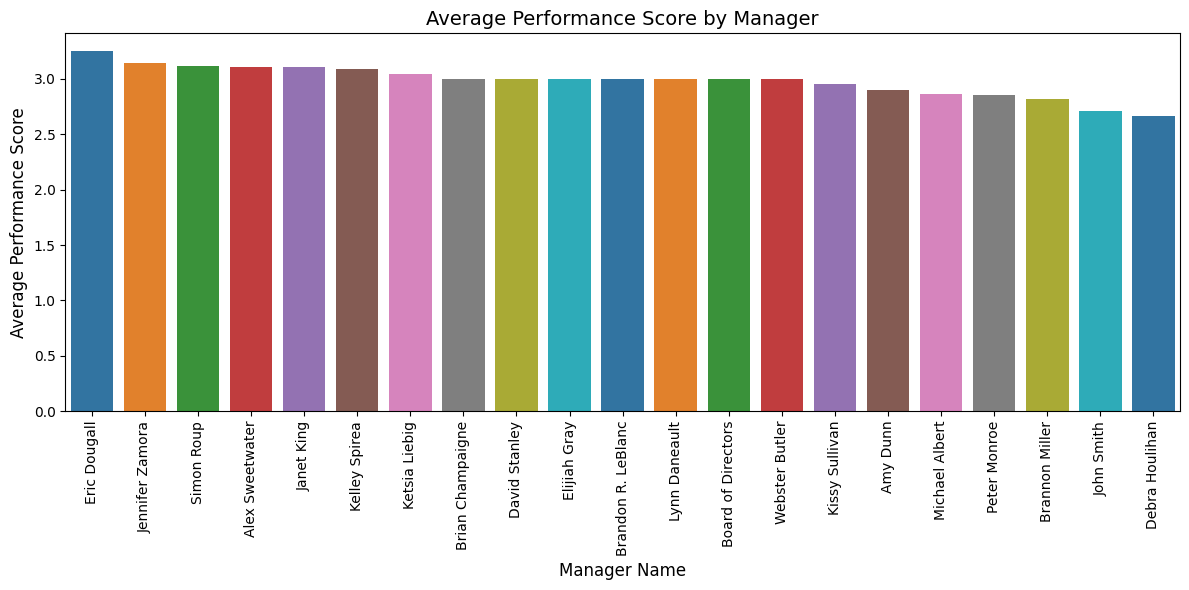

In [ ]:
# calc avg performance score
manager_performance = df.groupby('ManagerName')['PerfScoreID'].mean().reset_index()

# sort by performance score desc.
manager_performance = manager_performance.sort_values(by='PerfScoreID', ascending=False)

plt.figure(figsize=(12, 6))
sns.barplot(
    data=manager_performance,
    x='ManagerName',
    y='PerfScoreID',
    palette='tab10'
)

plt.title('Average Performance Score by Manager', fontsize=14)
plt.xlabel('Manager Name', fontsize=12)
plt.ylabel('Average Performance Score', fontsize=12)
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

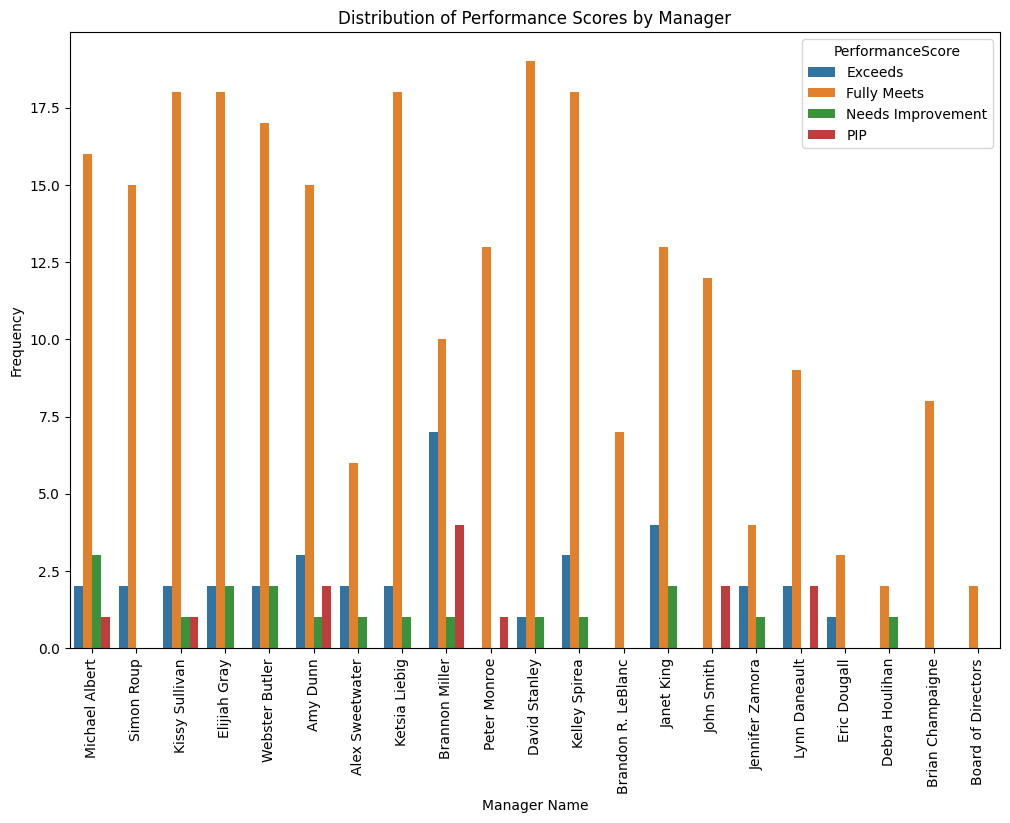

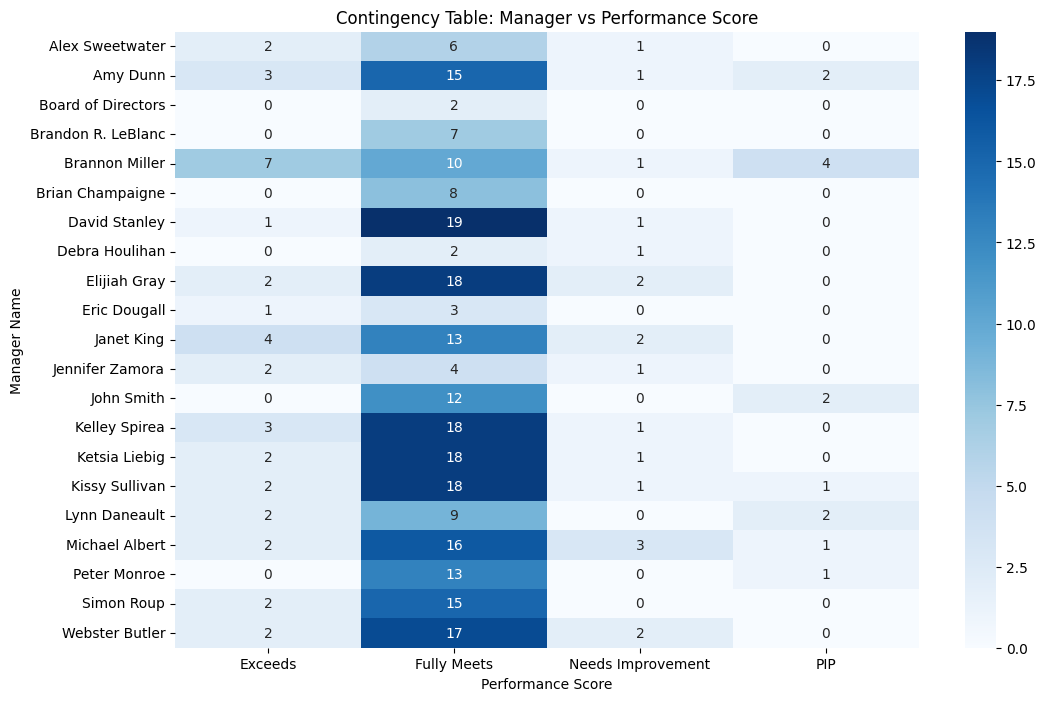

Chi-squared statistic: 67.00
p-value: 0.2494
There is no statistically significant association between Managers and Employees Performance Score.


In [ ]:
# distribution of performance scores by manager
plt.figure(figsize=(12, 8))
sns.countplot(x='ManagerName',
              hue='PerformanceScore',
              data=df)
plt.xlabel('Manager Name')
plt.ylabel('Frequency')
plt.title('Distribution of Performance Scores by Manager')
plt.xticks(rotation=90)
plt.show()

# contingency table between manager and performance score
contingency_table = pd.crosstab(df['ManagerName'], stat_df['PerformanceScore'])

# heatmap contingency table
plt.figure(figsize=(12, 8))
sns.heatmap(contingency_table, annot=True, cmap='Blues', fmt='d')
plt.xlabel('Performance Score')
plt.ylabel('Manager Name')
plt.title('Contingency Table: Manager vs Performance Score')
plt.show()

# chi-squared test  between manager and performance score
chi2, p, dof, expected = chi2_contingency(contingency_table)
print(f'Chi-squared statistic: {chi2:.2f}')
print(f'p-value: {p:.4f}')

if p < 0.05:
    print("There is a statistically significant association between Managers and Employees Performance Score.")
else:
    print("There is no statistically significant association between Managers and Employees Performance Score.")

### **Summary**
**1. Relationship between Manager and Employee Performance Score:**
- The Chi-squared test statistic (67.00) and p-value (0.2494) indicate that there is no statistically significant association between the manager and an employee's performance score.
- This means that employees' performance scores do not vary significantly based on who they report to, as seen in the bar graph. Most managers maintain relatively similar average performance scores among their teams, with minor variations. Rather performance is driven by other systematic factors like:
  - training programs
  - role clarity

However, as seen above managers like Webster Butler (high terminations but average performance) may excel at output but struggle with retention. so efforts should be towards decreasing the retention gap.
Recommendations:
- train managers on stay interview techniques and conflict resolution.
- conduct exit interviews to identify non-performance turnover drivers to identify root cause.

# **Organizational Diversity and Inclusion Analysis**
- What is the overall diversity profile of the organization?
- What are our best recruiting sources if we want to ensure a diverse organization?

<ipython-input-48-4f3e80ef0d2c>:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(x=column, data=df, palette="tab10")


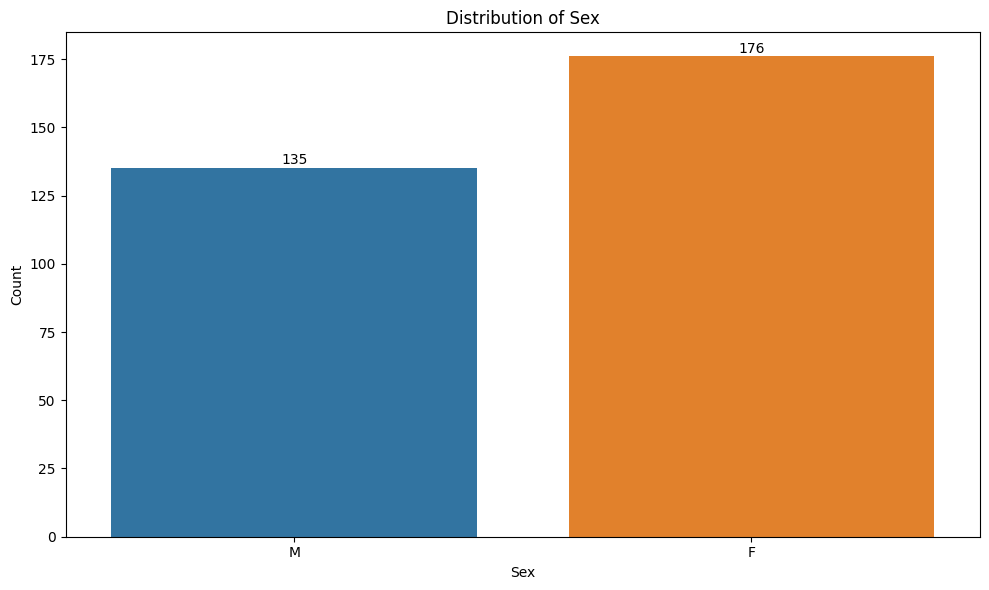

<ipython-input-48-4f3e80ef0d2c>:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(x=column, data=df, palette="tab10")


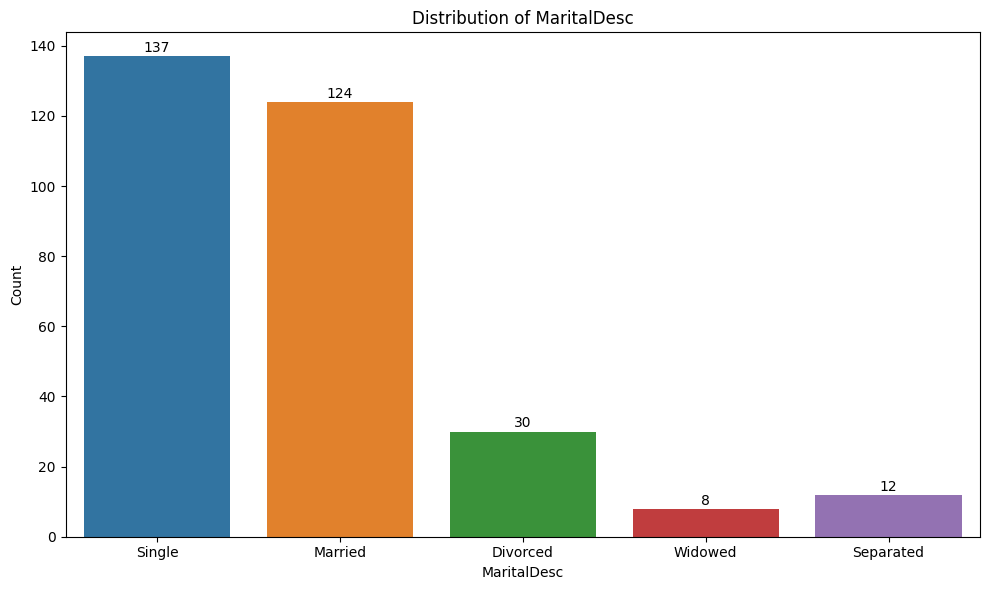

<ipython-input-48-4f3e80ef0d2c>:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(x=column, data=df, palette="tab10")


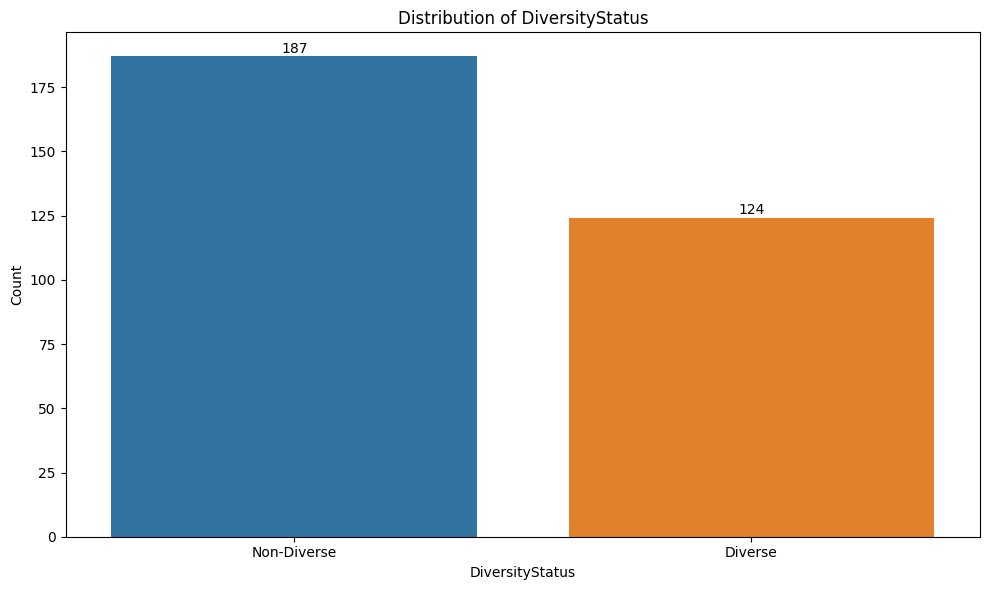

<ipython-input-48-4f3e80ef0d2c>:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(x=column, data=df, palette="tab10")


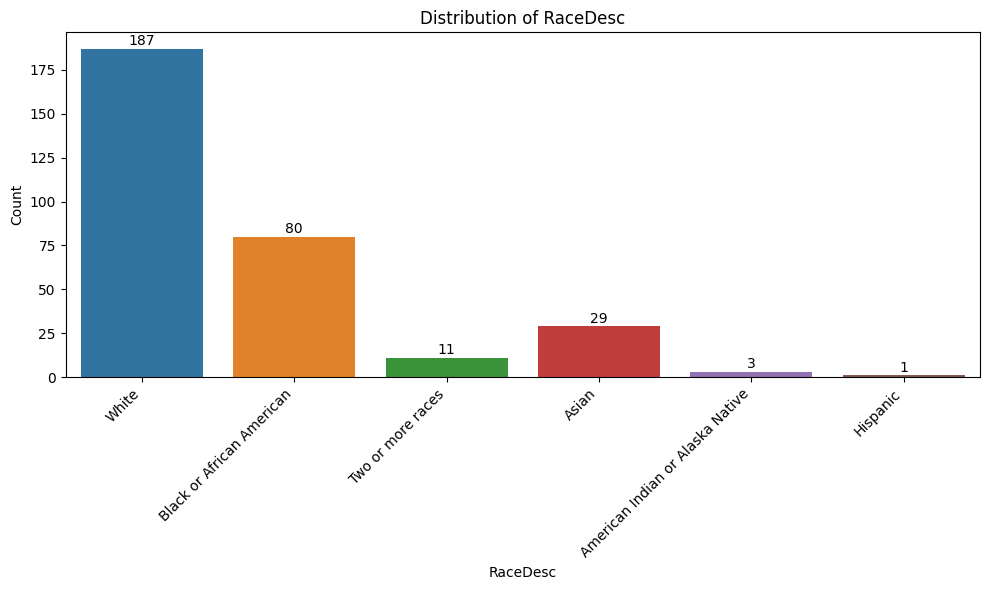

In [ ]:
# columns to analyze
diversity_columns = ['Sex', 'MaritalDesc', 'DiversityStatus', 'RaceDesc']

for column in diversity_columns:
    plt.figure(figsize=(10, 6))

    ax = sns.countplot(x=column, data=df, palette='tab10')

    for p in ax.patches:
        ax.text(
            p.get_x() + p.get_width() / 2,
            p.get_height() + 0.3,
            f'{p.get_height():.0f}',
            ha='center',
            va='bottom')

    plt.title(f"Distribution of {column}")
    plt.xlabel(column)
    plt.ylabel("Count")

    # rotate x-axis labels if there are large num of unique values
    if len(df[column].unique()) > 5:
        plt.xticks(rotation=45, ha='right')

    plt.tight_layout()
    plt.show()

<ipython-input-49-f1e2d48689ce>:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=['Diverse Hires', 'Diverse Hires from Diversity Fair'],


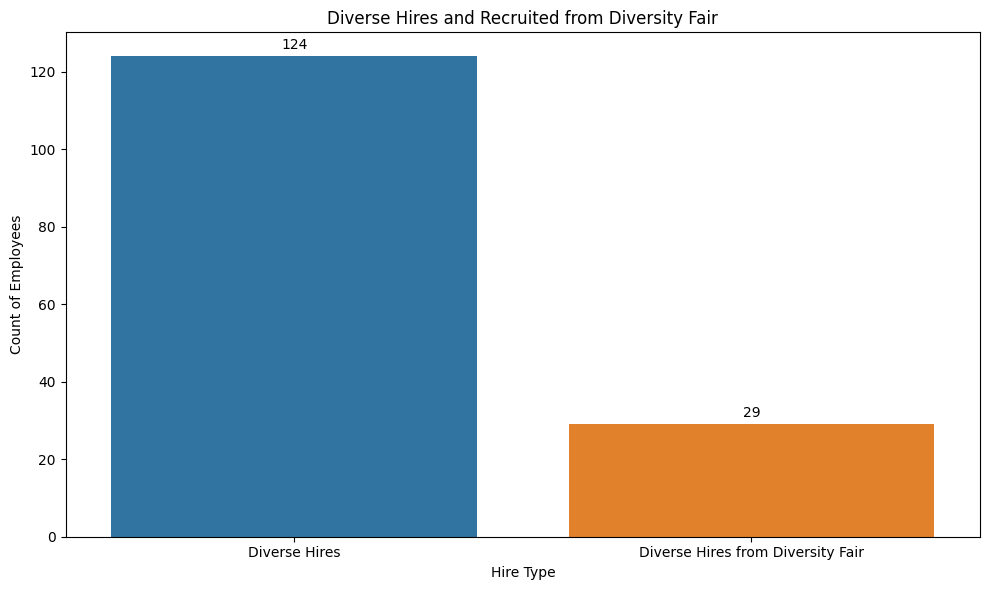

In [ ]:
# filter for diverse employees
diverse_hires = df[df['DiversityStatus'] == 'Diverse']

# filter diverse hires from the diversity fair
diverse_from_fair = diverse_hires[diverse_hires['FromDiversityJobFairID'] == 1]

# number of diverse hires and those from the diversity fair
total_diverse_hires = diverse_hires.shape[0]
diverse_from_fair_count = diverse_from_fair.shape[0]

plt.figure(figsize=(10, 6))
sns.barplot(x=['Diverse Hires', 'Diverse Hires from Diversity Fair'],
            y=[total_diverse_hires, diverse_from_fair_count],
            palette='tab10')

for i, value in enumerate([total_diverse_hires, diverse_from_fair_count]):
    plt.text(i, value + 2, f'{value}', ha='center')

plt.title('Diverse Hires and Recruited from Diversity Fair')
plt.ylabel('Count of Employees')
plt.xlabel('Hire Type')

plt.tight_layout()
plt.show()

<ipython-input-50-72657716f978>:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='RecruitmentSource',


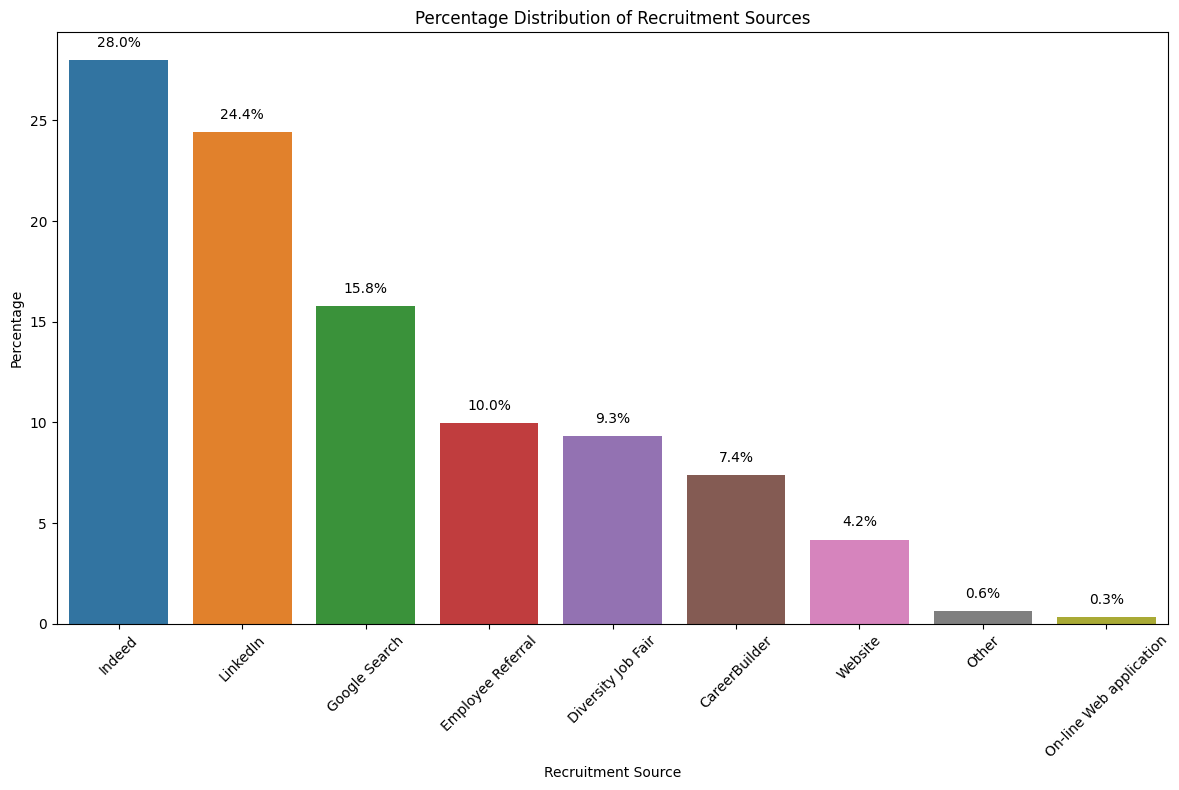

In [ ]:
# count of each recruitment source
recruitment_counts = df['RecruitmentSource'].value_counts()

# calc percentage
total_employees = len(df)
recruitment_percentage = (recruitment_counts / total_employees) * 100

recruitment_df = recruitment_percentage.reset_index()
recruitment_df.columns = ['RecruitmentSource', 'Percentage']


plt.figure(figsize=(12, 8))
ax = sns.barplot(x='RecruitmentSource',
                 y='Percentage',
                 data=recruitment_df,
                 palette='tab10')

# add percentage on top of bars
for p in ax.patches:
    ax.text(p.get_x() + p.get_width() / 2,
            p.get_height() + 0.5,
            f'{p.get_height():.1f}%',
            ha='center',
            va='bottom')

plt.title('Percentage Distribution of Recruitment Sources')
plt.xlabel('Recruitment Source')
plt.ylabel('Percentage')
plt.xticks(rotation=45, ha='center')
plt.tight_layout()
plt.show()

### **Summary**
**1. Gender Diversity:**
- The organization has 176 female employees and 135 male employees.
- Female employees make up approximately 56.6% of the workforce, and male employees make up 43.4%.

**2. Diversity Status:**
- There are 187 non-diverse hires and 125 diverse hires.
- Diverse hires represent approximately 40.1% of the workforce, while non-diverse hires account for 59.9%.

**3. Best Recruiting Sources for Ensuring Diversity:**
- 124 diverse hires have been recruited, and 29 of these hires came from diversity fairs.
- This implies that diversity fairs contributed to approximately 23.4% of all diverse hires.

Although not the sole source of diverse hiring, diversity fairs are an effective source for improving the organization's diversity profile. Addditionally, Indeed and LinkedIn are the best recruitment sources for the organization.

# **Salary Analysis**
- Are there areas of the company where pay is not equitable?

## **By Department & Position**

<ipython-input-51-9ad6320f91b5>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(
<ipython-input-51-9ad6320f91b5>:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


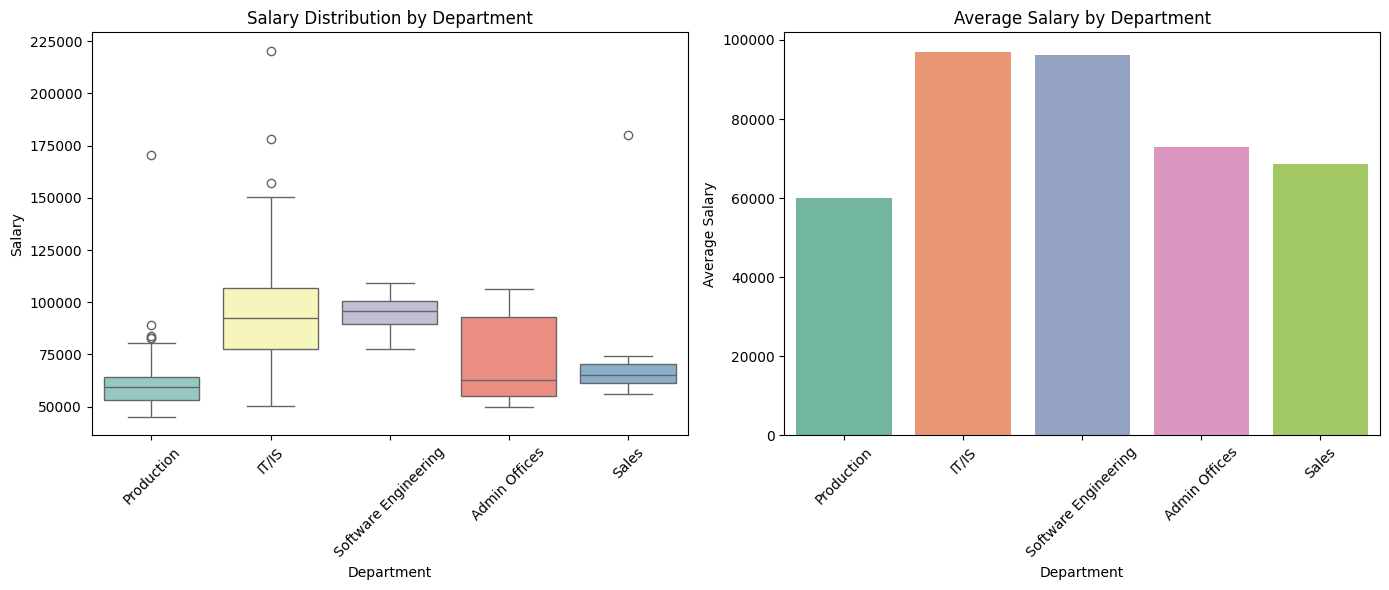

In [ ]:
plt.figure(figsize=(14, 6))

# 1: salary by department
plt.subplot(1, 2, 1)
sns.boxplot(
    data=df[df['Department']!= 'Executive Office'],
    x='Department',
    y='Salary',
    palette='Set3'
)
plt.title('Salary Distribution by Department')
plt.xlabel('Department')
plt.ylabel('Salary')
plt.xticks(rotation=45)

# 2: avg salary by department
plt.subplot(1, 2, 2)

filtered_dept = df[df['Department'] != 'Executive Office'].drop_duplicates(subset=['Department'])

sns.barplot(
    data=filtered_dept,
    x='Department',
    y='DeptAverageSalary',
    palette='Set2'
)
plt.title('Average Salary by Department')
plt.xlabel('Department')
plt.ylabel('Average Salary')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

<ipython-input-52-2712c83e5db2>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


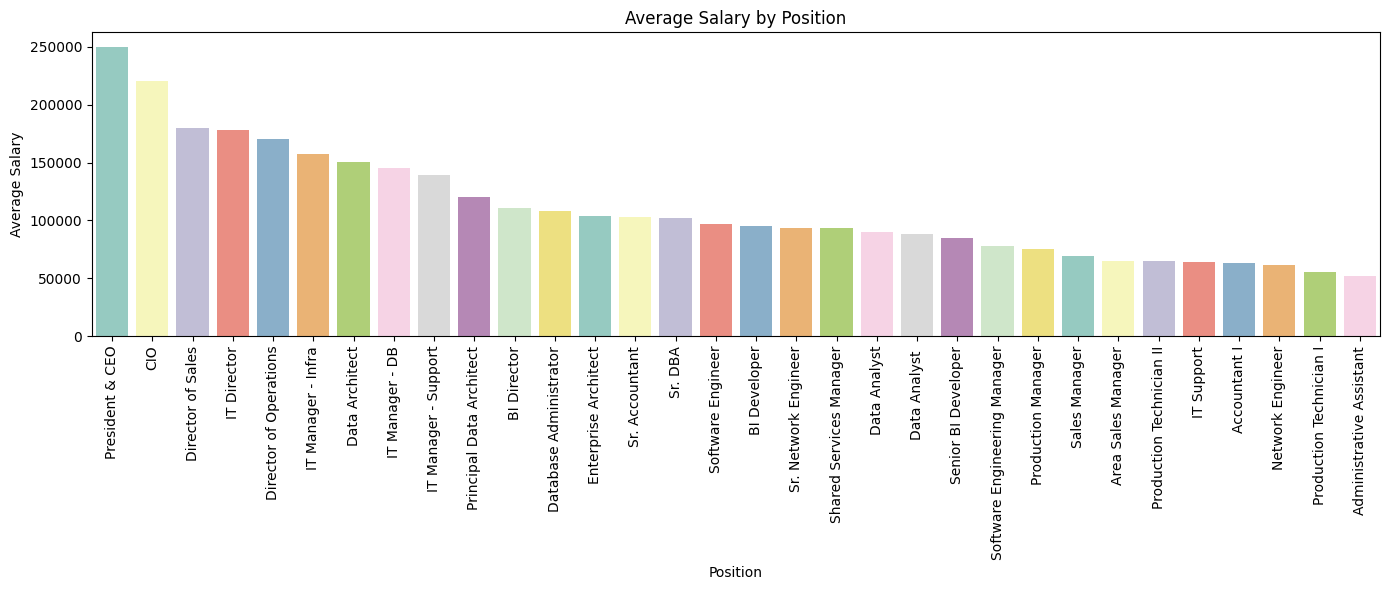

In [ ]:
# avg salary by position
plt.figure(figsize=(14, 6))

avg_salary_position = df.groupby('Position', as_index=False)['Salary'].mean().sort_values(by='Salary', ascending=False)
sns.barplot(
    data=avg_salary_position,
    x='Position',
    y='Salary',
    palette='Set3'
)
plt.title('Average Salary by Position')
plt.xlabel('Position')
plt.ylabel('Average Salary')
plt.xticks(rotation=90, fontsize=10)

plt.tight_layout()
plt.show()

## **By Race**

<ipython-input-53-9913c47337a3>:5: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(
<ipython-input-53-9913c47337a3>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
<ipython-input-53-9913c47337a3>:19: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(
<ipython-input-53-9913c47337a3>:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


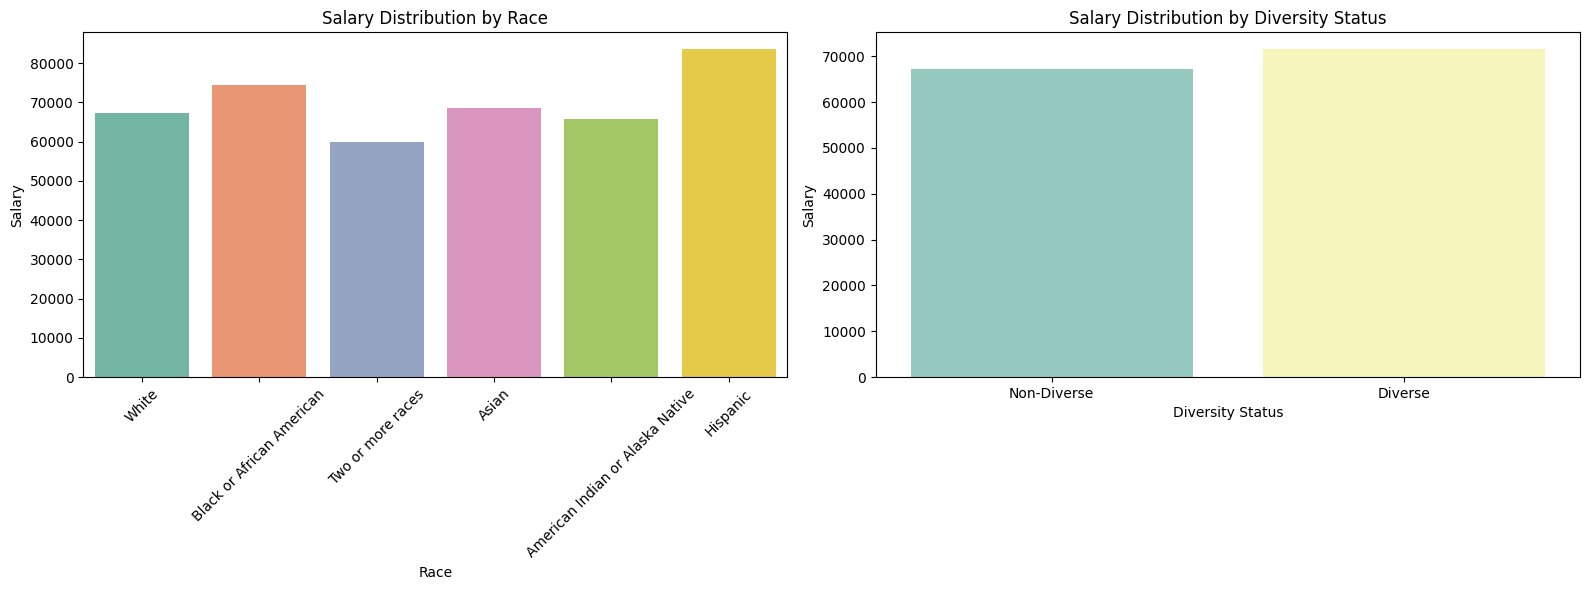

In [ ]:
plt.figure(figsize=(16, 6))

# 1: salary by race
plt.subplot(1, 2, 1)
sns.barplot(
    data=df,
    x='RaceDesc',
    y='Salary',
    palette='Set2',
    ci=None
)
plt.title('Salary Distribution by Race')
plt.xlabel('Race')
plt.ylabel('Salary')
plt.xticks(rotation=45, fontsize=10)

# 2: salary by diversity
plt.subplot(1, 2, 2)
sns.barplot(
    data=df,
    x='DiversityStatus',
    y='Salary',
    palette='Set3',
    ci=None
)
plt.title('Salary Distribution by Diversity Status')
plt.xlabel('Diversity Status')
plt.ylabel('Salary')
plt.xticks(rotation=0, fontsize=10)

plt.tight_layout()
plt.show()

## **By Gender**

<ipython-input-54-27a368dbe750>:3: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(
<ipython-input-54-27a368dbe750>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


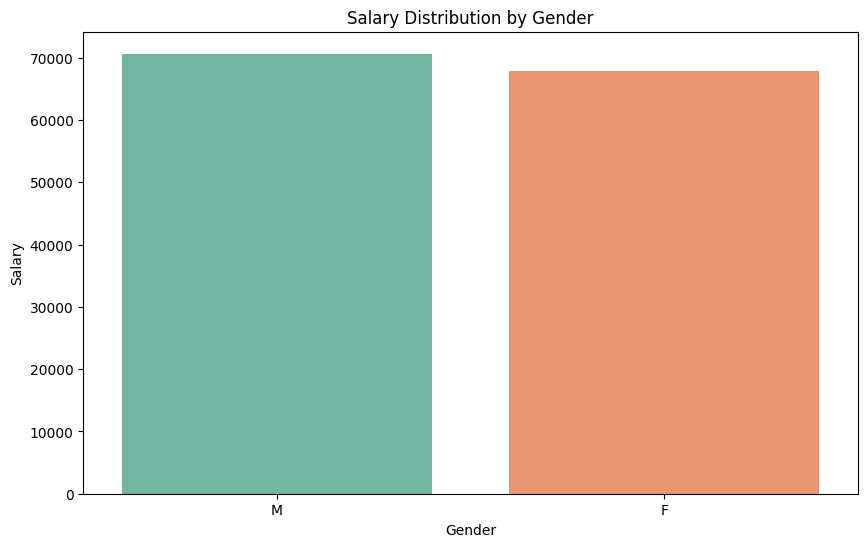

In [ ]:
# salary by gender
plt.figure(figsize=(10, 6))
sns.barplot(
    data=df,
    x='Sex',
    y='Salary',
    palette='Set2', ci=None
)
plt.title('Salary Distribution by Gender')
plt.xlabel('Gender')
plt.ylabel('Salary')
plt.show()

In [ ]:
# Shapiro-Wilk test (normality)
shapiro_test_salary = shapiro(stat_df['Salary'])

# Levene's test (equal variance)
male_salary = stat_df[stat_df['GenderID'] == 1]['Salary']
female_salary = stat_df[stat_df['GenderID'] == 0]['Salary']

levene_test = levene(male_salary, female_salary, center='mean')

print(f"Shapiro-Wilk Test for Salary Normality: Statistic = {shapiro_test_salary.statistic}, P-Value = {shapiro_test_salary.pvalue}")
if shapiro_test_salary.pvalue < 0.05:
    print("The Salary data does not follow a normal distribution.")
else:
    print("The Salary data follows a normal distribution.")

print(f"\nLevene's Test for Equal Variances: Statistic = {levene_test.statistic}, P-Value = {levene_test.pvalue}")
if levene_test.pvalue < 0.05:
    print("There is a significant difference in variances between male and female salaries.")
else:
    print("Variances between male and female salaries are approximately equal.")

Shapiro-Wilk Test for Salary Normality: Statistic = 0.8846436115383249, P-Value = 1.43771494955863e-14
The Salary data does not follow a normal distribution.

Levene's Test for Equal Variances: Statistic = 3.821787045589317, P-Value = 0.05149159453769581
Variances between male and female salaries are approximately equal.


The Shapiro-Wilk Test indicates the Salary data does not follow a normal distribution, violating the normality assumption required for a t-test. However, Levene's test shows that the assumption of equal variances between male and female salaries holds, as the p-value is above 0.05, indicating no significant difference in variances. Since the t-test requires both normality and equal variances to be met, we will use the Mann-Whitney U test, which is a non-parametric test.

In [ ]:
# Mann-Whitney U Test
u_stat, p_value = mannwhitneyu(male_salary, female_salary, alternative='two-sided')

print(f"U-Statistic: {u_stat}")
print(f"P-Value: {p_value}")

if p_value < 0.05:
    print("There is a significant difference in salaries between genders.")
else:
    print("There is no significant difference in salaries between genders.")

U-Statistic: 12891.5
P-Value: 0.1983383927950536
There is no significant difference in salaries between genders.


### **Summary**
The salary distribution between race, diversity status, and gender do not vary dramatically indicating salary is is equitable in those areas.

The highest paid roles are President & CEO, CIO, and Director of Sales, with salaries exceeding 200,000 dollars on average. These are executive roles that expect a higher salary range. The lowest roles are IT Support, Production Technician I/II, and Administrative Assistant and earn under $60,000 on average. This drop in average salaries between positions is to be expected as these lower-tier positions tend to be entry or non-specialized roles. However, the organization should enquire futher evalutaion to ensure the employees are being fairly compensated and satisfied.